In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import optuna

In [22]:
# Definir a seed
seed = 42
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed2)





(0.0, 0.0)


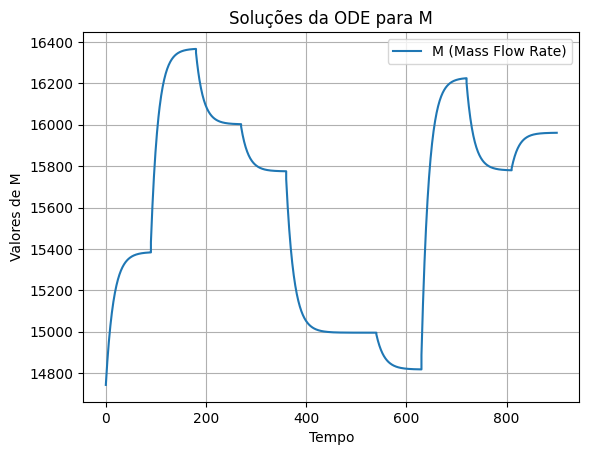

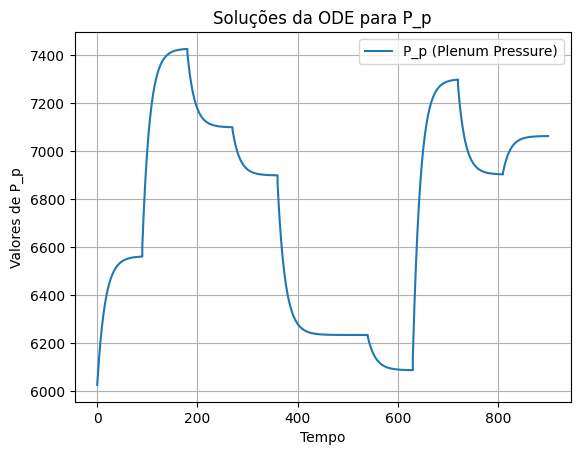

In [23]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4000, 5000)  # Corrigido para o intervalo desejado
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value


def ale():
  return np.random.uniform(400, 500)
# Instanciando o gerador com uma seed
seed = 42  # Altere a seed conforme necessário
p1_gen = P1Generator(seed)

def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0   # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1] - P_out)

    dmdt = (A1 / Lc) * (phi_value * 4000 - x[1])
    dPdt = ((C1**2) * (x[0] - alpha * K_nu * z)) / nu_P

    return dmdt, dPdt

stati = fsolve(Estacionario, [100000, 100000])

print(Estacionario(stati))

def Sistemas(x0, P1_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p')

    # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0  # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5  # φ

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))

    rhs = vertcat(
        (A1 / Lc) * (phi_value * p - (x[1])),
        (C1**2) * (x[0] - alpha * K_nu * z)
    ) / nu_P

    ode = {'x': x, 'ode': rhs , 'p': p}
    F = integrator('F', 'cvodes', ode, {'tf': 90})

    #
    t_eval = np.linspace(0, 90, 120)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    for i in range(len(t_eval)):
        res = F(x0=x0, p=P1_value)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next

        # Check for steady state
        if np.all(np.abs(x_next - x0) < zeronum):
            sol = sol[:i+1]
            t_eval = t_eval[:i+1]
            break

        # Update initial state
        x0 = x_next

    return sol, P1_value, t_eval

# Loop de geração de dados
def Loop(loops, stati):
    estados = []
    p1_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:
            x0 = stati  # Inicializa com o estado estacionário
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()
        sol, P1_aleatorio, t_eval = Sistemas(x0, P1_v)
        estados.append(sol)
        p1_total.append(P1_aleatorio)

        # Tempo Total
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, t_total

aaaa, PlotP1, Plott = Loop(10, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]
P_p_final = Ploty[:, 1]

# Plotar os resultados
plt.figure()
plt.plot(Plott, Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')
plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(Plott, Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()




In [50]:

# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], np.repeat(P1_values, len(t_eval) // len(P1_values))[:len(M[:-1])]))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Padronizar Dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


In [53]:

# Redimensionar as entradas para (batch_size, timesteps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Função de objetivo para Optuna
def objective(trial):
    # Hiperparâmetros a serem otimizados
    n_units = trial.suggest_int('n_units', 10, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Construção do modelo
    model = keras.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(n_units, return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2))

    # Configuração do otimizador
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Treinar o modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=128,
                        verbose=0,
                        callbacks=[early_stopping])
    
    # Avaliar o modelo e retornar o valor da métrica que estamos otimizando
    val_loss = model.evaluate(X_test, y_test, verbose=0)
    
    return val_loss[0]  # Queremos minimizar o val_loss


In [52]:



# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Imprimir o melhor conjunto de hiperparâmetros
print(study.best_params)



[I 2024-10-13 00:19:15,432] A new study created in memory with name: no-name-0c8a2aa6-44c3-43d9-baec-c633618f706b
c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-10-13 00:19:30,776] Trial 0 finished with value: 1.5751984119415283 and parameters: {'n_units': 19, 'dropout_rate': 0.07996695996336217, 'learning_rate': 3.3485118047092563e-05}. Best is trial 0 with value: 1.5751984119415283.
[I 2024-10-13 00:19:44,117] Trial 1 finished with value: 1.2799651622772217 and parameters: {'n_units': 11, 'dropout_rate': 0.20852325268091196, 'learning_rate': 1.8614291383686505e-05}. Best is trial 1 with value: 1.2799651622772217.
[I 2024-10-13 00:20:14,967] Trial 2 finished with value: 1.1803418397903442 and paramet

In [26]:
X_train.shape



(599, 3, 1)

In [41]:
# Treinar o modelo final com os melhores parâmetros
best_params = study.best_params
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(best_params['n_units'], return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(best_params['dropout_rate']))
model.add(layers.Dense(2))

optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])



model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])



early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=128,
                    verbose=2,
                    #callbacks=[early_stopping]
                    )






Epoch 1/100


c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 - 8s - 2s/step - loss: 0.6188 - mae: 0.6635 - val_loss: 0.1083 - val_mae: 0.2813
Epoch 2/100
5/5 - 0s - 33ms/step - loss: 0.0717 - mae: 0.2124 - val_loss: 0.1287 - val_mae: 0.3312
Epoch 3/100
5/5 - 0s - 36ms/step - loss: 0.0622 - mae: 0.1907 - val_loss: 0.0312 - val_mae: 0.1455
Epoch 4/100
5/5 - 0s - 44ms/step - loss: 0.0438 - mae: 0.1754 - val_loss: 0.0738 - val_mae: 0.2246
Epoch 5/100
5/5 - 0s - 40ms/step - loss: 0.0273 - mae: 0.1252 - val_loss: 0.0088 - val_mae: 0.0612
Epoch 6/100
5/5 - 0s - 37ms/step - loss: 0.0198 - mae: 0.1084 - val_loss: 0.0193 - val_mae: 0.1240
Epoch 7/100
5/5 - 0s - 37ms/step - loss: 0.0140 - mae: 0.0885 - val_loss: 0.0126 - val_mae: 0.0777
Epoch 8/100
5/5 - 0s - 36ms/step - loss: 0.0132 - mae: 0.0835 - val_loss: 0.0156 - val_mae: 0.0974
Epoch 9/100
5/5 - 0s - 37ms/step - loss: 0.0103 - mae: 0.0710 - val_loss: 0.0066 - val_mae: 0.0584
Epoch 10/100
5/5 - 0s - 37ms/step - loss: 0.0093 - mae: 0.0713 - val_loss: 0.0047 - val_mae: 0.0465
Epoch 11/100
5/5 - 0s -

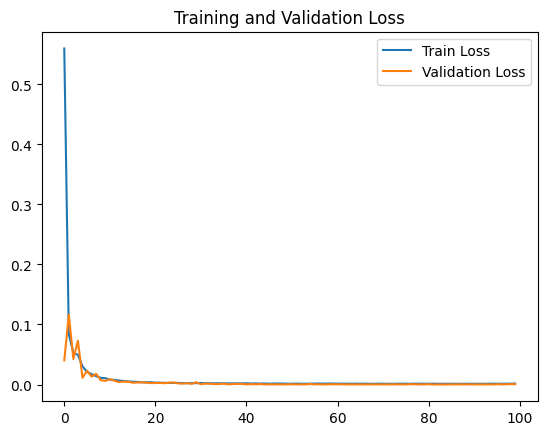

In [35]:

# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Ultimo P1: 4181.824967207101
Valores P1:[4374.5401188473625, 4950.714306409916, 4731.993941811405, 4598.658484197036, 4156.018640442437, 4155.994520336202, 4058.0836121681996, 4866.176145774935, 4601.115011743209, 4708.072577796045]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━

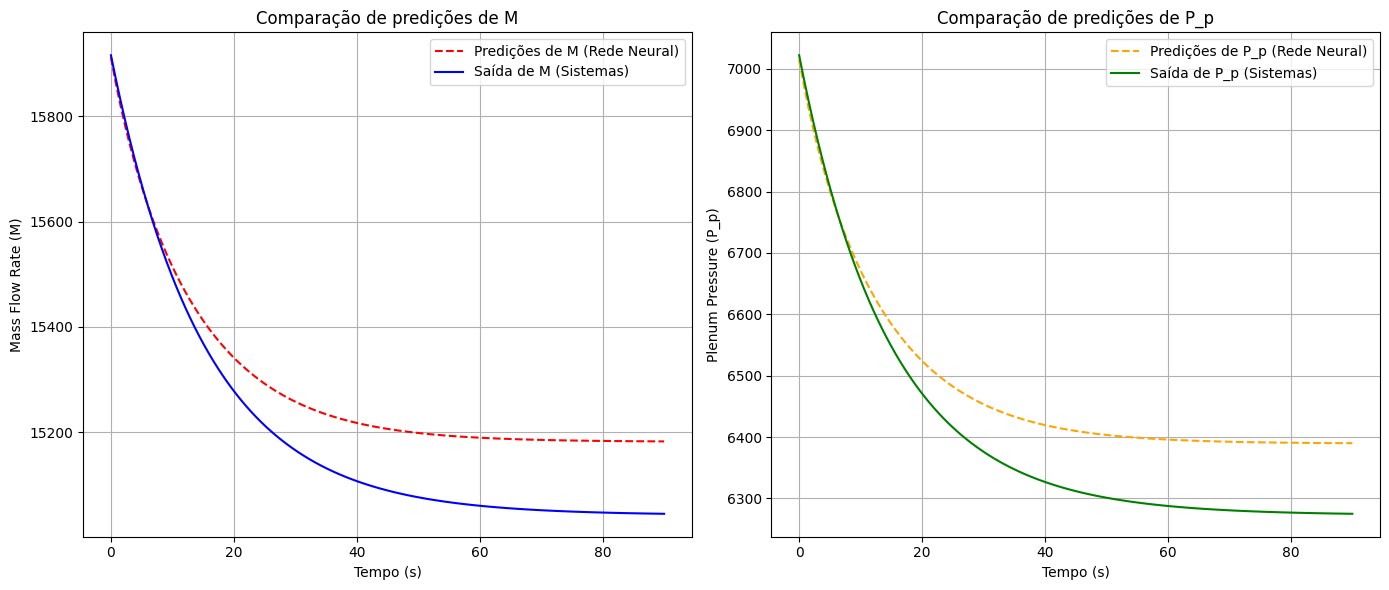

In [40]:
# Inicializando as listas para armazenar as predições da rede neural
M_predicoes = []
P_p_predicoes = []

# Usar os últimos valores de M e P_p como ponto de partida
M_atual = M[-1]
P_p_atual = P_p[-1]
ultimo_P1 = p1_gen.P1()
print()
print(f"Ultimo P1: {ultimo_P1}")
print(f"Valores P1:{PlotP1}")
# Criar uma sequência de 360 pontos no intervalo de 0 a 30
t_eval = np.linspace(0, 90, 120)

# Iterar para gerar predições consecutivas correspondentes a 360 pontos
for _ in range(120):

    # Criar a entrada com o formato (M_atual, P_p_atual, ultimo_P1)
    entrada = np.array([[M_atual, P_p_atual, ultimo_P1]]) # The original error was caused because M_atual and P_p_atual were 1-D arrays
    entrada_normalizada = scaler_X.transform(entrada)

    # Realizar a predição
    predicao = model.predict(entrada_normalizada)
    predicao_original = scaler_y.inverse_transform(predicao)

    # Extrair os valores preditos para M e P_p
    M_predito = predicao_original[0, 0]
    P_p_predito = predicao_original[0, 1]
    # Armazenar as predições
    M_predicoes.append(M_predito)
    P_p_predicoes.append(P_p_predito)

    # Atualizar os valores para a próxima iteração
    M_atual = M_predito
    P_p_atual = P_p_predito

# Gerar os valores de saída da função Sistemas
sol_sistemas, _, t_eval_sistemas = Sistemas([M[-1], P_p[-1]], ultimo_P1)
M_sistemas = sol_sistemas[:, 0]
P_p_sistemas = sol_sistemas[:, 1]

# Plotar as previsões e os valores de saída da função Sistemas
plt.figure(figsize=(14, 6))

# Plotagem do M
plt.subplot(1, 2, 1)
plt.plot(t_eval, M_predicoes, label='Predições de M (Rede Neural)', color='red', linestyle='--')
plt.plot(t_eval_sistemas, M_sistemas, label='Saída de M (Sistemas)', color='blue', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação de predições de M')
plt.legend()
plt.grid(True)

# Plotagem do P_p
plt.subplot(1, 2, 2)
plt.plot(t_eval, P_p_predicoes, label='Predições de P_p (Rede Neural)', color='orange', linestyle='--')
plt.plot(t_eval_sistemas, P_p_sistemas, label='Saída de P_p (Sistemas)', color='green', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação de predições de P_p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


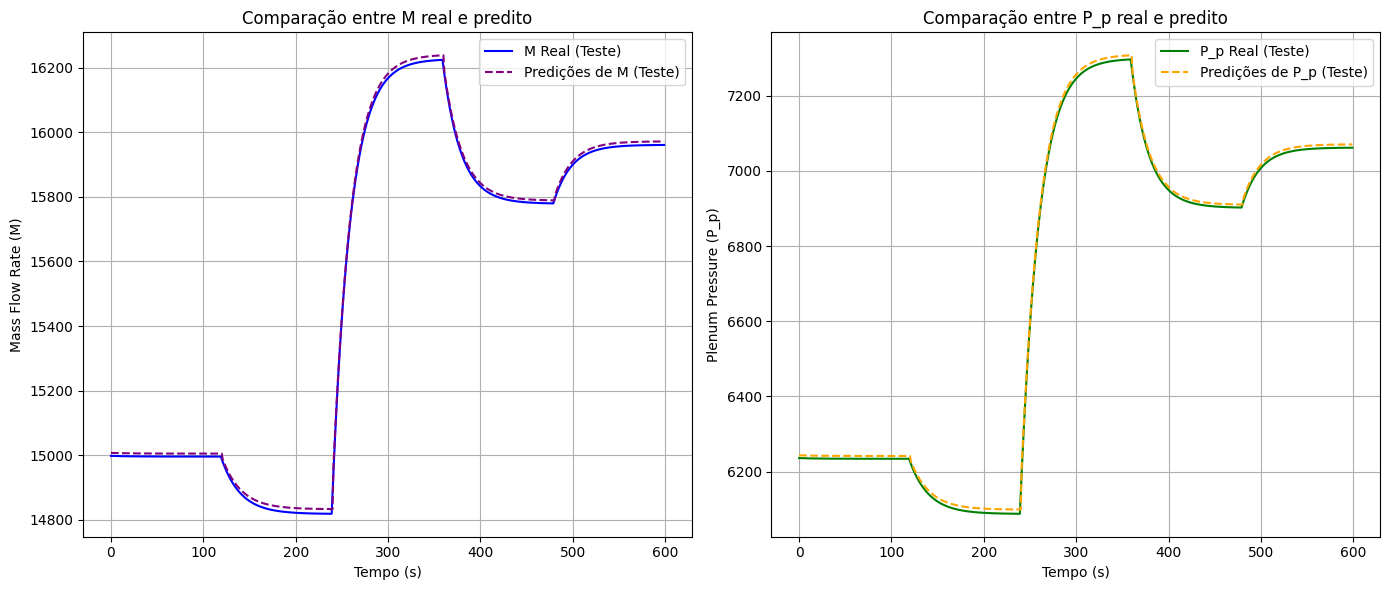

In [37]:
# Separar os dados de entrada (X_test) e as saídas reais (y_test)
rename_X = X_test.reshape(600,3)  # Dados de entrada padronizadas (X_test)
rename_y = y_test.reshape(600,2) # Saídas reais padronizadas (y_test)

# 1. Prever os valores de saída usando o modelo treinado (predições padronizadas)
y_test_pred = model.predict(rename_X)

# 2. despadronizadas as predições (y_test_pred) e os dados reais (rename_y)
y_test_pred_desnormalized = scaler_y.inverse_transform(y_test_pred)  # Previsões despadronizadas
y_test_real_desnormalized = scaler_y.inverse_transform(rename_y)  # Saídas reais despadronizadas

# 3. Separar as colunas de saídas reais (M e P_p)
M_real = y_test_real_desnormalized[:, 0]  # Mass Flow Rate real
P_p_real = y_test_real_desnormalized[:, 1]  # Plenum Pressure real

# 4. Separar as colunas de predições (M e P_p preditos)
M_test_pred = y_test_pred_desnormalized[:, 0]  # Mass Flow Rate predito
P_p_test_pred = y_test_pred_desnormalized[:, 1]  # Plenum Pressure predito

# 5. Preparar o eixo de tempo para o teste
t_eval_test = np.linspace(0, len(M_test_pred) - 1, len(M_test_pred))

# 6. Plotando os resultados - comparações das predições com os valores reais
plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(t_eval_test, M_real, label='M Real (Teste)', color='blue', linestyle='-')  # Saída real de M
plt.plot(t_eval_test, M_test_pred, label='Predições de M (Teste)', color='purple', linestyle='--')  # Predições de M
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(t_eval_test, P_p_real, label='P_p Real (Teste)', color='green', linestyle='-')  # Saída real de P_p
plt.plot(t_eval_test, P_p_test_pred, label='Predições de P_p (Teste)', color='orange', linestyle='--')  # Predições de P_p
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()




